I believe that my implementation of the Lucy-Richardson deconvolution isn't perfect. This notebook is to test the effects.

In [58]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import pandas as pd
from DeconvolvePSF.lucy import convolve, convolveStar, makeGaussian, calcChi2
from skimage.restoration import richardson_lucy as rl
from subprocess import check_output
from itertools import izip

import scipy
import numpy.lib.index_tricks as itricks
import pdb
from WavefrontPSF.psf_evaluator import Moment_Evaluator
#from scipy.signal import convolve2d as convolve
#from DeconvolvePSF.lucy import deconvolve

In [59]:
import DeconvolvePSF.colormaps as cmaps
plt.register_cmap(name='viridis', cmap=cmaps.viridis)
plt.set_cmap(cmaps.viridis)

In [60]:
# these give the deconvolved stars
out_base = '/nfs/slac/g/ki/ki18/des/swmclau2/DeconvOutput/'

dir_str = check_output('ls -d %s*/'%out_base, shell = True) #get all the directories in our output dir
dir_list = dir_str.split('/\n')[:-1]#skip the lsat one, its ''

expids = [int(direc.lstrip('%s'%out_base) ) for direc in dir_list]
expids = sorted(expids)
bad_expid_idxs = [2,5, 6]
#14
#5
expid = expids[5]
#expid = 179966
print(expid)

#out_base = '/nfs/slac/g/ki/ki18/des/cpd/DeconvOutput/'
deconv_dir = out_base + '{0:08d}'.format(expid)
# not sure what stars these really are? the combined psfex + deconv?
deconvmodel_loc = out_base + '{0:08d}/{0}_stars.npy'.format(expid)
deconvopt_loc = out_base + '{0:08d}/{0}_opt.npy'.format(expid)
deconvatm_loc = out_base + '{0:08d}/{0}_atm.npy'.format(expid)
deconvstarsminusopt_loc = out_base + '{0:08d}/{0}_stars_minus_opt.npy'.format(expid)
deconvdata_loc = out_base + '{0:08d}/{0}_data.npy'.format(expid)
deconvpsfex_loc = out_base + '{0:08d}/{0}_psfexalone.npy'.format(expid)
deconvdf_loc = out_base + '{0:08d}/results.h5'.format(expid)
deconvdf_key = 'table_{0:08d}'.format(expid)

deconvopt_immediate_loc = '/nfs/slac/g/ki/ki18/des/swmclau2/DeconvOutput/{0:08d}/{0}_opt_test.npy'.format(expid)

jamierod_results_path = '/nfs/slac/g/ki/ki18/des/cpd/jamierod_results.csv'
mesh_directory = '/nfs/slac/g/ki/ki22/roodman/ComboMeshesv20'
# directory containing the input data files
base_directory = '/nfs/slac/g/ki/ki18/des/cpd/psfex_catalogs/SVA1_FINALCUT/psfcat/'

149440


In [61]:
#Look I'm a comment this isn't rawnb
atmpsf = np.load(deconvatm_loc)
optpsf = np.load(deconvopt_loc)
starminusopt = np.load(deconvstarsminusopt_loc)
model = np.load(deconvmodel_loc)
psfexpsf = np.load(deconvpsfex_loc)
stars = np.load(deconvdata_loc)

df = pd.read_hdf(deconvdf_loc, deconvdf_key)

In [62]:
def deconvolve(PSF,phi_tilde,psi_0=None,mask=None,mu0=0.0,niterations=10,convergence=-1,chi2Level=0.0,extra=False):
    """ Implementation of the Richardson-Lucy deconvolution algorithm.
    Notation follows Lucy 1974, Eqn 15 and 14.  Add  noise term following
    Snyder et al 1993.
    Arguments
    ---------
    PSF          known Point Spread Function
    phi_tilde    measured object
    psi_0        starting guess for deconvolution
    mask         =0 for bins where we know that recovered image has no flux 
    mu0          background noise estimate
    """

    # normalize PSF
    PSF = PSF / np.sum(PSF)

    # if no initial guess, make one from 2nd moments of input image - PSF
    if psi_0 is None:
        # calculate Moments of psi_tilde and PSF, subtract and

        # calculate moments
        evaluator = Moment_Evaluator()

        # try a better starting guess - based on our knowledge of the PSF
        image_moments = evaluator(phi_tilde)
        PSF_moments = evaluator(PSF)

        #TODO what to do if makeGaussian throws an error?
        # subtract 2nd order moments in quadrature, use an object with the difference
        Mxx = image_moments['Mxx'][0] - PSF_moments['Mxx'][0]
        Myy = image_moments['Myy'][0] - PSF_moments['Myy'][0]
        Mxy = image_moments['Mxy'][0] - PSF_moments['Mxy'][0]

        psi_r = makeGaussian(phi_tilde.shape,Mxx,Myy,Mxy)
        #sometimes this fails if the observation is too non-gaussian
        if np.any(np.logical_or( np.isinf(psi_r), np.isnan(psi_r))):
            psi_r = phi_tilde #trying this out; otherwise we'll just have to raise errors/hell
        
    else:
        # initial guess
        psi_r = np.abs(psi_0)

    # mask starting guess
    if mask != None:    
        psi_r = psi_r * mask

    # normalize starting guess
    psi_r = psi_r / np.sum(psi_r)
    
    #TODO Maybe this should be an error instead of a warning.
    if np.any(np.isnan(psi_r)):
        raise RuntimeWarning("NaN in initial guess, skip this value. ")
                
    # mask image too
    if mask != None:
        phi_tilde = phi_tilde * mask
        
    # find normalization for measured image
    beta = np.sum(phi_tilde)
        
        
    # now iterate, either until convergence reached or fixed number of iterations are done
    psiByIter = []
    diffByIter = []
    chi2ByIter = []
    iteration = 0
    continueTheLoop = True
    
    diff_sums = []
    
    while continueTheLoop: 
        
        #plt.imshow(psi_r,interpolation = 'None', vmin = 0, vmax = phi_tilde.max())
        #plt.show()
        
        # calculate next approximation to psi
        phi_r = beta*convolve(psi_r,PSF) + mu0
        psi_rplus1 = psi_r * convolveStar((phi_tilde+mu0)/phi_r,PSF)

        # mask the next iteration
        if mask != None:
            psi_rplus1 = psi_rplus1 * mask
        
        # normalize it
        psi_rplus1 = psi_rplus1 / np.sum(psi_rplus1)

        # check for convergence if desired
        #Why are the psiByIter appends inside the convergence test?
        if convergence>0:
            # compare psi_r and psi_rplus1
            psiByIter.append(psi_rplus1)
            diff = np.sum(np.abs(psi_rplus1 - psi_r))
            print diff
            diffByIter.append(diff)
            if diff<convergence:
                continueTheLoop = False

        # also calculate how close to a solution we are
        chi2 = calcChi2(PSF,psi_rplus1,phi_tilde,beta,mu0)
        chi2ByIter.append(chi2)
        if chi2<chi2Level:
            continueTheLoop = False
        
        # check for Chi2 level
                

        # always check number of iterations
        if iteration==niterations-1:
            continueTheLoop = False
            
        diff_sum = np.abs((psi_rplus1-psi_r).sum() )
        #print diff_sum
        diff_sums.append(diff_sum)

        # save for next iteration
        iteration+=1     
        psi_r = np.array(psi_rplus1)  # does a deepcopy


    #TODO rescale deconv by flux

    # we are done!
    if extra:
        return psi_rplus1,diffByIter,psiByIter,chi2ByIter
    else:
        
        diff_sums = np.array(diff_sums)
        
        #print diff_sums.mean(), diff_sums.std()
        
        return psi_rplus1  

0.584775226707
0.347490644943
0.572823455812
0.864409959199
1.03094303457
1.12386722947
1.24037029917
1.12824530587
1.24023287162
0.946737714997
0.450614111601
5.22668109723
8.70325086397
3.41845705819
1.41004534273
0.300319575368
0.23815531538
0.480747356635
0.636590718607
0.399719082668
0.471934085439
0.242089607136
0.425506077057
0.304169234713
0.52203992129
0.338817966948
0.901682275111
4.90512250626
5.12332895142
1.42997665885
1.22137930874
5.8091214702
8.05557052424
1.43579690585
1.73168393831
2.59961387482
1.98418998531
21.0879932317
21.4316682036
6.06232850009
4.41597822802
11.7627357806
12.2941194799
56.134314832
57.7245903038
10.4224654518
7.22599998229
5.10851411162
6.5470086088
7.91766091403


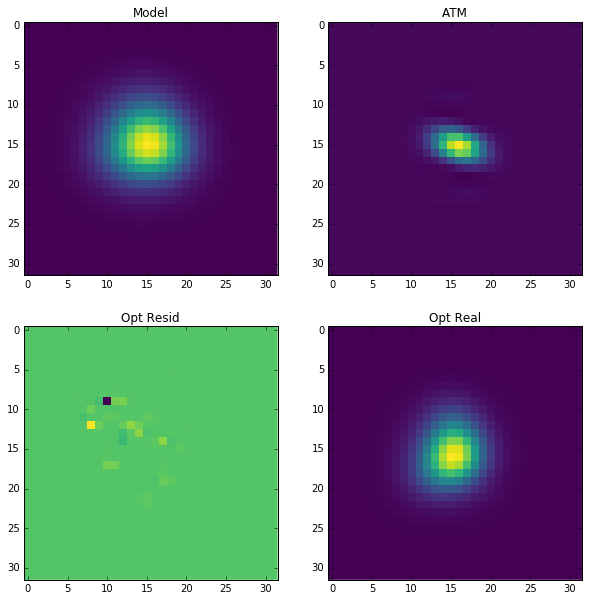

In [63]:
idx = 0
dec = deconvolve(atmpsf[idx], model[idx],psi_0=None,mask=None,mu0=0,convergence=1e-2,chi2Level=0.,niterations=50, extra= False)
fig = plt.figure(figsize = (10,10))

vmin = None
vmax = None#np.max([atmpsf[idx].max(), model[idx].max(), optpsf[idx].max()])

plt.subplot(222)
plt.title('ATM')
plt.imshow(atmpsf[idx], interpolation = 'None', vmin = vmin, vmax = vmax)
plt.subplot(221)
plt.title('Model')
plt.imshow(model[idx], interpolation = 'None', vmin = vmin, vmax = vmax)
plt.subplot(223)
plt.title('Opt Resid')
plt.imshow(dec, interpolation = 'None', vmin = vmin, vmax = vmax)
plt.subplot(224)
plt.title('Opt Real')
plt.imshow(optpsf[idx], interpolation = 'None', vmin = vmin, vmax = vmax)

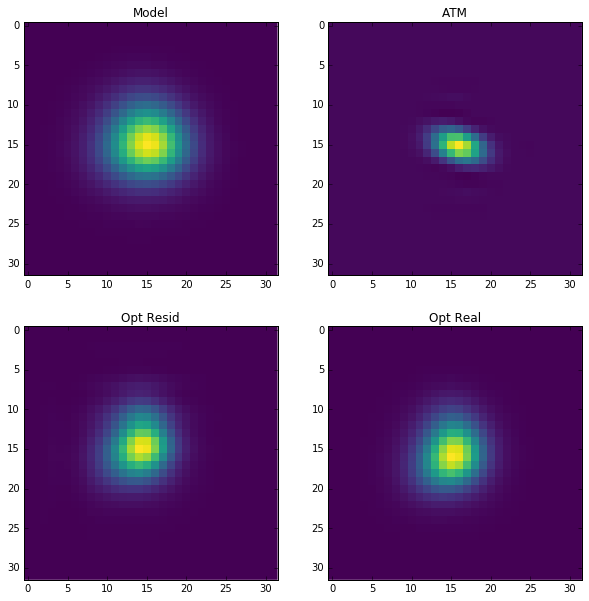

In [64]:
dec_sk = rl(model[idx], atmpsf[idx],iterations = 50, clip = True)
fig = plt.figure(figsize = (10,10))

plt.subplot(222)
plt.title('ATM')
plt.imshow(atmpsf[idx], interpolation = 'None')
plt.subplot(221)
plt.title('Model')
plt.imshow(model[idx], interpolation = 'None')
plt.subplot(223)
plt.title('Opt Resid')
plt.imshow(dec_sk, interpolation = 'None')
plt.subplot(224)
plt.title('Opt Real')
plt.imshow(optpsf[idx], interpolation = 'None')

0.222702388448
0.0569181462503
0.0282478288269
0.0171232191101
0.0111565744698
0.00764445372934
0.00545632419939
0.00403901767892
0.00307924125794
0.00240364167241
0.00191790967963
0.00156213759519
0.00129256390808
0.00108200622777
0.000915345454127
0.000782016232121
0.000673430457156
0.000584305147854
0.000510723688925
0.000449060090462
0.00039724613064
0.000353308963009
0.000316401063217
0.000284827657387
0.000257459806513
0.000233854896697
0.000213360069597
0.000195507963841
0.000179865906539
0.000166074295299
0.000153828484649
0.000142958480986
0.000133185154051
0.000124372221263
0.000116326484558
0.000109024536906
0.00010242028352
9.64567145492e-05
9.10209181151e-05
8.60403259804e-05
8.14821140677e-05
7.72755344028e-05
7.34039351472e-05
6.98011070858e-05
6.64290476064e-05
6.32649440584e-05
6.03023025662e-05
5.75281779708e-05
5.49184489934e-05
5.24650201225e-05


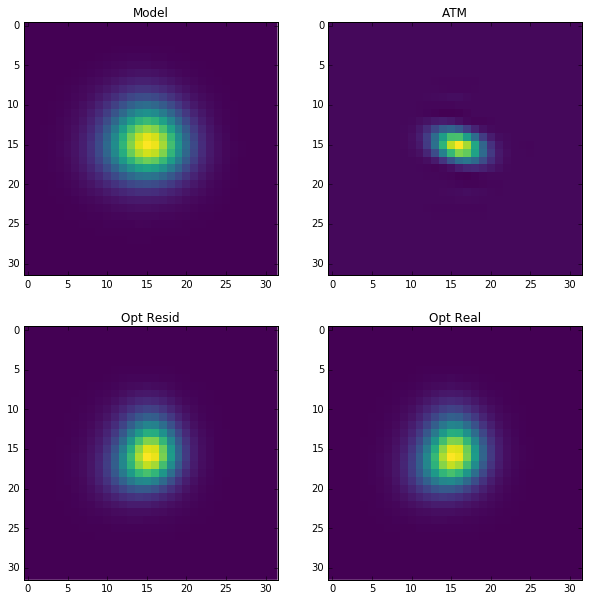

In [65]:
dec = deconvolve(atmpsf[idx], model[idx],psi_0=model[idx],mask=None,mu0=atmpsf[idx].mean(),convergence=1e-6,chi2Level=0.,niterations=50, extra= False)
fig = plt.figure(figsize = (10,10))

vmin = None
vmax = None#np.max([atmpsf[idx].max(), model[idx].max(), optpsf[idx].max()])

plt.subplot(222)
plt.title('ATM')
plt.imshow(atmpsf[idx], interpolation = 'None', vmin = vmin, vmax = vmax)
plt.subplot(221)
plt.title('Model')
plt.imshow(model[idx], interpolation = 'None', vmin = vmin, vmax = vmax)
plt.subplot(223)
plt.title('Opt Resid')
plt.imshow(dec, interpolation = 'None', vmin = vmin, vmax = vmax)
plt.subplot(224)
plt.title('Opt Real')
plt.imshow(optpsf[idx], interpolation = 'None', vmin = vmin, vmax = vmax)

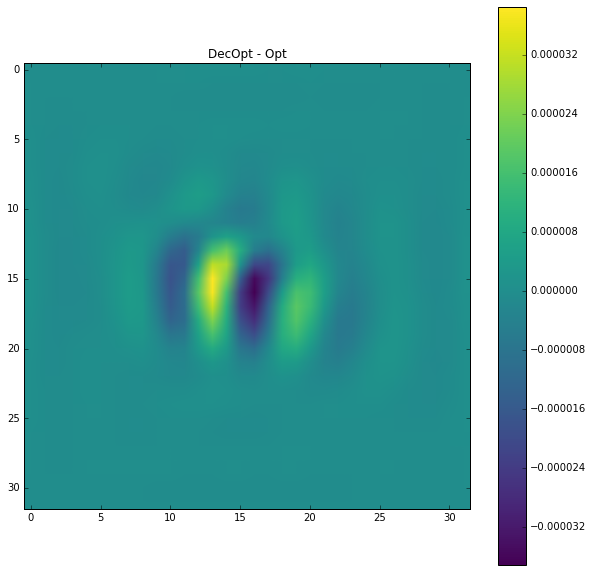

In [66]:
plt.figure(figsize = (10,10))
plt.title('DecOpt - Opt')
im = plt.imshow(dec - optpsf[idx]) 
plt.colorbar(im)